In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

## Cold dark matter

To generate realizations with pyHalo you have to supply a number of keyword arguments to specify mass definitions, lens/source redshift, etc. This is made somewhat easier through the preset models, as demonstrated below. 

realization contains 18099 halos.


Text(0,0.5,'n(M)')

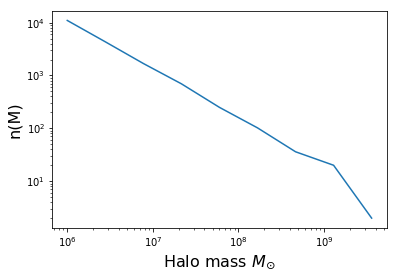

In [2]:
from pyHalo.preset_models import CDM

zlens, zsource = 0.5, 2.5
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=10)
print('realization contains '+str(len(realizationCDM.halos))+' halos.')
halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(halo_masses, bins=np.logspace(6, 10, 10))

plt.loglog(m[0:-1], N)
plt.xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
plt.ylabel('n(M)', fontsize=16)

## pyhalo is designed to be used with the software lenstronomy (https://github.com/sibirrer/lenstronomy)
In one step, you can go from a pyhalo realization to an instance of LensModel

In [4]:
lens_model_list, lens_redshift_array, kwargs_halos, _ = realizationCDM.lensing_quantities()
# you can ignore the last argument unless you're using a profile with numerically-computed deflection angles

from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = realizationCDM.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)

We can look at the projected mass of the lens model with line of sight and subhalos only. The code automatically generates negative convergence sheets that subtract the mean mass rendered in halos, which is why some areas will appear underdense (blue) relative to the mean dark matter density, while other areas (halos) are overdense.

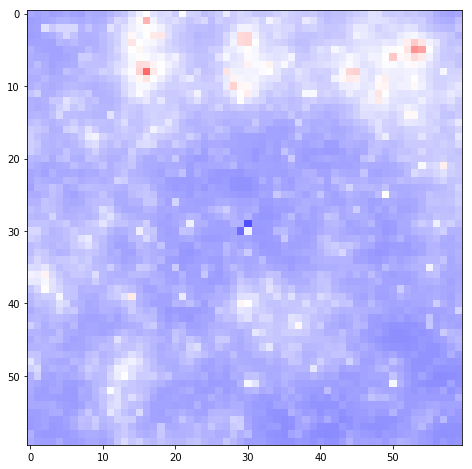

In [5]:
npix = 60 
_x = _y = np.linspace(-1.2, 1.2, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')

Things look more interesting if you include a macromodel to compute the full convergence field, and then subtract off the mass profile of the main deflector at the end...

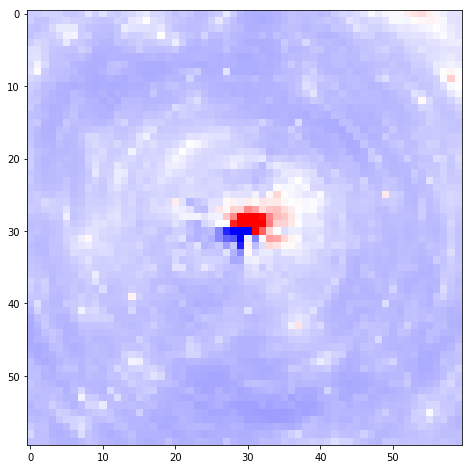

In [6]:
# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_subs_nonlinear = kappa_full - kappa_macro
plt.imshow(kappa_subs_nonlinear, vmin=-0.1, vmax=0.1, cmap='bwr')

# Warm dark matter

You can just as easily generate realizations of warm dark matter halos using the preset model WDMLovell2020, or WDMGeneral (see documentation in present_models). As you can probably surmise from the title, WDMLovell2020 is the parameterization of the halo mass function presented in Lovell 2020 (https://arxiv.org/pdf/2003.01125.pdf). 

realization contains 2862 halos.


Text(0,0.5,'n(M)')

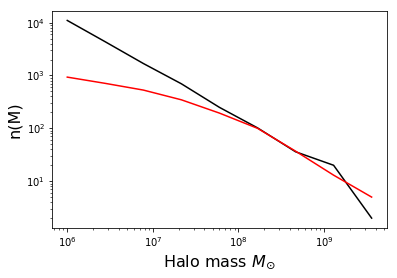

In [7]:
from pyHalo.preset_models import WDM

log10_half_mode_mass = 7.3
realizationWDM = WDM(zlens, zsource, log10_half_mode_mass, cone_opening_angle_arcsec=10)

print('realization contains '+str(len(realizationWDM.halos))+' halos.')
halo_masses = [halo.mass for halo in realizationWDM.halos]
Nwdm, mwdm = np.histogram(halo_masses, bins=np.logspace(6, 10, 10))

plt.loglog(m[0:-1], N, color='k')
plt.loglog(mwdm[0:-1], Nwdm, color='r')
plt.xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
plt.ylabel('n(M)', fontsize=16)

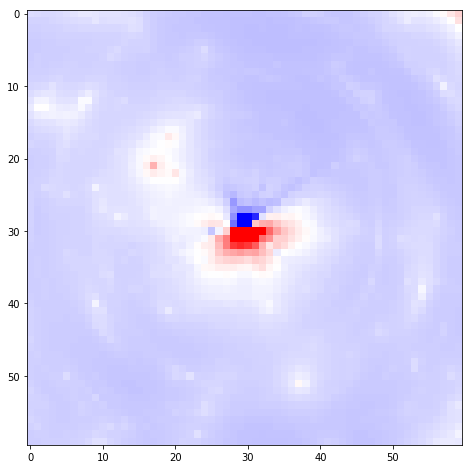

In [8]:
lens_model_list_WDM, lens_redshift_array_WDM, kwargs_halos_WDM, _ = realizationWDM.lensing_quantities()

lens_model_list_full_WDM = lens_model_list_macro + lens_model_list_WDM
lens_redshift_list_full_WDM = [zlens, zlens] + list(lens_redshift_array_WDM)
kwargs_lens_full_WDM = kwargs_macromodel + kwargs_halos_WDM

lens_model_full_WDM = LensModel(lens_model_list_full_WDM, zlens, zsource, lens_redshift_list_full_WDM, 
                                cosmo=astropy_instance, multi_plane=True)

kappa_full_WDM = lens_model_full_WDM.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_WDM).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_full_WDM - kappa_macro, vmin=-0.1, vmax=0.1, cmap='bwr')